# Memory Based Collaborative Filter

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Sample data (user, item, rating)
data = [
    {"user": "Alice", "item": "Guitar", "rating": 5, "description": "String instrument"},
    {"user": "Alice", "item": "Drums", "rating": 3, "description": "Percussion instrument"},
    {"user": "Alice", "item": "Violin", "rating": 4, "description": "String instrument"},  
    {"user": "Bob", "item": "Guitar", "rating": 1, "description": "String instrument"},
    {"user": "Bob", "item": "TV", "rating": 5, "description": "Television"},
    {"user": "Bob", "item": "Radio", "rating": 4, "description": "Audio equipment"},
    {"user": "Bob", "item": "Laptop", "rating": 3, "description": "Computer"}, 
    {"user": "Charlie", "item": "Guitar", "rating": 4, "description": "String instrument"},
    {"user": "Charlie", "item": "Piano", "rating": 5, "description": "Keyboard instrument"},
    {"user": "Charlie", "item": "Drums", "rating": 4, "description": "Percussion instrument"},
    {"user": "Charlie", "item": "Microphone", "rating": 3, "description": "Audio equipment"}, 
    {"user": "David", "item": "Guitar", "rating": 2, "description": "String instrument"}, 
    {"user": "David", "item": "Violin", "rating": 4, "description": "String instrument"},  
    {"user": "David", "item": "Piano", "rating": 3, "description": "Keyboard instrument"}, 
    {"user": "David", "item": "Microphone", "rating": 2, "description": "Audio equipment"}, 
]

# Convert data to DataFrame
ratings = pd.DataFrame(data)
ratings

,user,item,rating,description
0,Alice,Guitar,5,String instrument
1,Alice,Drums,3,Percussion instrument
2,Alice,Violin,4,String instrument
3,Bob,Guitar,1,String instrument
4,Bob,TV,5,Television
5,Bob,Radio,4,Audio equipment
6,Bob,Laptop,3,Computer
7,Charlie,Guitar,4,String instrument
8,Charlie,Piano,5,Keyboard instrument
9,Charlie,Drums,4,Percussion instrument


## User Based 

In [3]:
def compute_user_similarity(data):
    """Compute user similarity using Pearson correlation coefficient"""
    # Pivot data to get user-item matrix
    user_item_matrix = data.pivot_table(index='user', columns='item', values='rating', fill_value=0)
  
    # Compute user similarities
    corr_matrix = user_item_matrix.T.corr(method='pearson')
    
    return corr_matrix

def recommend_user_based(user, data, similarities, n=5):
    """Generate recommendations for a user"""
    # Get the user's ratings
    user_ratings = data[data['user'] == user].set_index('item')['rating']
    if user_ratings.empty:
        return pd.Series()
    
    # Find similar users
    similar_users = similarities[user].drop(user).nlargest(n)

    # Get all unique items in the dataset
    all_items = data['item'].unique()
    
    # Initialize recommendations Series with all items and their scores set to 0
    recommendations = pd.Series(0.0, index=all_items)

    # Generate recommendations
    for other_user, similarity in similar_users.items():
        other_user_ratings = data[data['user'] == other_user].set_index('item')['rating']
        for item in other_user_ratings.index:
            #item has been rated by the other user but not by this user
            if item in other_user_ratings and item not in user_ratings:
                recommendations[item] += other_user_ratings.get(item, 0) * similarity

    # Sort recommendations by score
    recommendations = recommendations.sort_values(ascending=False)
    return recommendations

In [4]:
# Compute user similarities
user_similarities = compute_user_similarity(ratings)
user_similarities

user,Alice,Bob,Charlie,David
user,,,,
Alice,1.000000,-0.468964,0.242536,0.397215
Bob,-0.468964,1.000000,-0.690286,-0.686968
Charlie,0.242536,-0.690286,1.000000,0.283946
David,0.397215,-0.686968,0.283946,1.000000


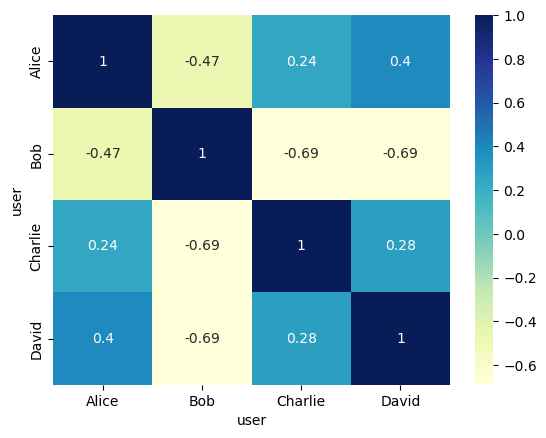

In [5]:
#use pearson distance between items
sns.heatmap(user_similarities, cmap="YlGnBu", annot=True) 
plt.show() 

In [6]:
# Example usage
user = "Alice"
recs = recommend_user_based(user, ratings, user_similarities,1)
print(f"\nRecommendations for user '{user}':")
print(recs)


Recommendations for user 'Alice':
Piano         1.191645
Microphone    0.794430
Guitar        0.000000
Drums         0.000000
Violin        0.000000
TV            0.000000
Radio         0.000000
Laptop        0.000000
dtype: float64


## Item Based

In [7]:
def compute_item_similarity(data):
    """Compute item-item similarity using cosine similarity"""
    # Pivot data to get user-item matrix
    user_item_matrix = data.pivot_table(index='user', columns='item', values='rating', fill_value=0)
    
    # Compute item similarities using cosine similarity
    item_similarities = cosine_similarity(user_item_matrix.T)
    
    # Convert the similarity matrix to a DataFrame
    item_similarities_df = pd.DataFrame(item_similarities, index=user_item_matrix.columns, columns=user_item_matrix.columns)
    
    return item_similarities_df

def recommend_item_based(user_id, data, similarities):
    """
    Get recommendations for a user based on item-item similarity.
    """
    # Get unique items in the dataset
    all_items = data['item'].unique()
    
    # Get user's ratings
    user_ratings = data[data['user'] == user_id].set_index('item')['rating']
    
    # Initialize dictionary to store predicted ratings for all items
    recommendations = {}
    
    # Iterate over all items
    for item in all_items:
        # Skip items the user has already rated
        if item in user_ratings.index:
            continue
        
        # Get similar items and their similarities
        similar_items = similarities[item]
        
        # Initialize variables for weighted sum and total similarity
        weighted_sum = 0
        total_similarity = 0
        
        # Iterate over similar items
        for similar_item, similarity in similar_items.items():
            # Check if the user has rated the similar item
            if similar_item in user_ratings.index:
                # Retrieve the user's rating for the similar item
                rating = user_ratings[similar_item]
                # Update weighted sum and total similarity only if the similarity is positive
                if similarity > 0:
                    weighted_sum += similarity * rating
                    total_similarity += similarity
        
        # Predict rating for the new item
        if total_similarity != 0:
            predicted_rating = weighted_sum / total_similarity
        else:
            # If there are no similar items rated by the user or all similarities are negative, return a default value
            predicted_rating = 0
        
        # Store predicted rating for the item
        recommendations[item] = predicted_rating
    
    # Sort predicted ratings by descending order
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_recommendations

In [8]:
# Compute item-item similarities using cosine similarity
item_similarities = compute_item_similarity(ratings)
item_similarities

item,Drums,Guitar,Laptop,Microphone,Piano,Radio,TV,Violin
item,,,,,,,,
Drums,1.000000,0.914140,0.000000,0.665640,0.685994,0.000000,0.000000,0.424264
Guitar,0.914140,1.000000,0.147442,0.654289,0.657438,0.147442,0.147442,0.729800
Laptop,0.000000,0.147442,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
Microphone,0.665640,0.654289,0.000000,1.000000,0.998868,0.000000,0.000000,0.392232
Piano,0.685994,0.657438,0.000000,0.998868,1.000000,0.000000,0.000000,0.363803
Radio,0.000000,0.147442,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
TV,0.000000,0.147442,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
Violin,0.424264,0.729800,0.000000,0.392232,0.363803,0.000000,0.000000,1.000000


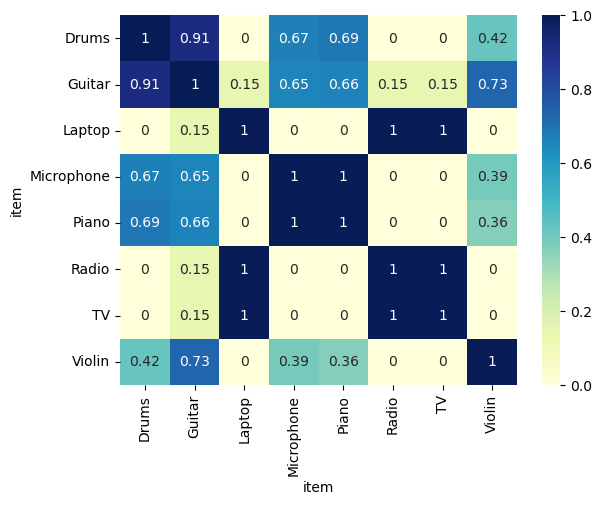

In [9]:
#use cosine distance between items
sns.heatmap(item_similarities, cmap="YlGnBu", annot=True) 
plt.show() 

In [10]:
# Example usage for item-item based recommendation
user = "Alice"
item_recs = recommend_item_based(user, ratings, item_similarities)
print(f"\nItem-based Recommendations for user '{user}':")
print(item_recs)


Item-based Recommendations for user 'Alice':
[('TV', 5.0), ('Radio', 5.0), ('Laptop', 5.0), ('Microphone', 3.99337002868907), ('Piano', 3.9832735009667815)]
